In [1]:
print("meowmeow")

print("hello?")

print("hehehaha")

meowmeow
hello?
hehehaha


In [2]:
print("kaiyi test")

print("weeeeeee")
print("weyuwuye")

kaiyi test
weeeeeee
weyuwuye


In [2]:
import cv2 # Will be used for edge detection further on
import os 
import numpy as np  # For numerical operations
from PIL import Image, ImageEnhance  # For image loading and augmentation
import matplotlib.pyplot as plt  # For visualization
from sklearn.preprocessing import LabelEncoder  # For encoding labels
import random  # For random transformations


In [3]:
from PIL import Image, ImageEnhance, ImageFilter


# Set Parameters
target_size = (224, 224)  # Standard input size for CNN
rotation_prob = 0.4  # 40% chance of rotation
saturation_prob = 0.5  # 50% chance of saturation change
min_saturation = 0.7  # Min saturation level
max_saturation = 1.3  # Max saturation level
blur_prob = 0.5  # 50% chance of blur
noise_prob = 0.5  # 50% chance of noise
min_crop_size = (70, 70)  # Minimum size of crop to avoid cutting off too much
padding = 80  # Padding to avoid cutting off important parts of the image
border_threshold = 5 # For the black border threshold count

# To crop out the edges
def auto_crop(img, padding=5, min_crop_size=(70, 70)):
    """
    Crops the image to the largest contour found using Canny edge detection.
    Returns the original image if no valid contour is found.
    """
    if isinstance(img, Image.Image):
        img_cv = np.array(img)
    else:
        img_cv = img.copy()

    gray = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, threshold1=50, threshold2=100)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv2.contourArea(c) > 300]  # slightly more relaxed

    if contours:
        # Use the largest contour
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        x = max(0, x - padding)
        y = max(0, y - padding)
        x_end = min(img.width, x + w + 2 * padding)
        y_end = min(img.height, y + h + 2 * padding)

        cropped = img.crop((x, y, x_end, y_end))
        
        # Only return cropped if it still has valid size
        if cropped.size[0] >= min_crop_size[0] and cropped.size[1] >= min_crop_size[1]:
            return cropped

    return img  # fallback: return original image if crop fails



# Function to resize image
def resize_image(img, target_size=(224, 224)):
    return img.resize(target_size, Image.LANCZOS)


# Function to apply random blur to an image
def apply_random_blur(img, prob=0.5):
    if random.random() < prob:
        radius = random.uniform(0.1, 2.0)  # Random blur radius
        return img.filter(ImageFilter.GaussianBlur(radius))
    return img  # No blur

# Function to add random noise to an image
def add_random_noise(img, prob=0.5):
    if random.random() < prob:
        img_array = np.array(img)
        noise = np.random.normal(0, 0.1, img_array.shape)  # Add Gaussian noise
        noisy_img_array = img_array + noise * 255  # Scale noise
        noisy_img_array = np.clip(noisy_img_array, 0, 255).astype(np.uint8)  # Ensure values are valid
        return Image.fromarray(noisy_img_array)
    return img  # No noise

# Function to adjust saturation
def adjust_saturation(img, min_factor=0.7, max_factor=1.3, prob=0.5):
    if random.random() < prob:
        factor = random.uniform(min_factor, max_factor)
        enhancer = ImageEnhance.Color(img)
        return enhancer.enhance(factor)
    return img  # No change


def rotate_image(img, max_angle=10, rotation_prob=0.4):
    """Random rotation with proper border handling"""
    if random.random() < rotation_prob:
        angle = random.uniform(-max_angle, max_angle)
        
        # Rotate on expanded canvas
        rotated = img.rotate(angle, expand=True, resample=Image.BILINEAR)
        
        # Convert to numpy array for border detection
        np_img = np.array(rotated)
        
        if np_img.ndim == 3:  # Color image
            # Find non-black pixels (any channel > threshold)
            non_black = np.any(np_img > border_threshold, axis=2)
        else:  # Grayscale
            non_black = np_img > border_threshold
            
        if np.any(non_black):
            # Get bounding box coordinates
            rows = np.any(non_black, axis=1)
            cols = np.any(non_black, axis=0)
            y_min, y_max = np.where(rows)[0][[0, -1]]
            x_min, x_max = np.where(cols)[0][[0, -1]]
            
            # Crop and convert back to PIL
            cropped = rotated.crop((x_min, y_min, x_max, y_max))
            return cropped.resize(target_size, Image.LANCZOS)
    
    # Return original if no rotation or if border removal failed
    return img.resize(target_size, Image.LANCZOS) if rotation_prob else img

# Function to adjust brightness
def adjust_brightness(img, min_factor=0.9, max_factor=1.2, prob=0.5):
    if random.random() < prob:
        factor = random.uniform(min_factor, max_factor)
        enhancer = ImageEnhance.Brightness(img)
        return enhancer.enhance(factor)
    return img  # No change


#function to normalise image
def normalize_image(img_tensor):
            mean = torch.tensor([0.485, 0.456, 0.406], dtype=img_tensor.dtype).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225], dtype=img_tensor.dtype).view(3, 1, 1)
            return (img_tensor - mean) / std

# function to denormalise image:
def denormalize_image(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

# function to adjust contrast
def adjust_contrast(img, min_factor=1.1, max_factor=1.5, prob=0.5):
    if random.random() < prob:
        factor = random.uniform(min_factor, max_factor)
        enhancer = ImageEnhance.Contrast(img)
        return enhancer.enhance(factor)
    return img




### Attempted to remove super small images below 10kb

In [4]:
import torch
from collections import Counter
from PIL import Image
import os
import numpy as np

train_folder = "Train"
train_images = []
train_labels = []

# Define rare class threshold and augmentation params
rare_threshold = 150
extra_copies = 2

# Low-quality filtering thresholds
min_file_size_kb = 10
min_resolution = (40, 40)

# First, count class frequencies
all_labels = [int(f.split("__")[0]) for f in os.listdir(train_folder) if f.endswith(".png")]
class_counts = Counter(all_labels)
rare_classes = [cls for cls, count in class_counts.items() if count < rare_threshold]

print(f"Rare classes: {rare_classes}")

# Function to detect low-quality images
def is_low_quality(file_path):
    if os.path.getsize(file_path) < min_file_size_kb * 1024:
        return True
    try:
        img = Image.open(file_path)
        return img.width < min_resolution[0] or img.height < min_resolution[1]
    except:
        return True
    return False

for img_file in os.listdir(train_folder):
    if not img_file.endswith(".png"):
        continue

    img_path = os.path.join(train_folder, img_file)

    # Skip low-quality images
    if is_low_quality(img_path):
        print(f"Skipping low-quality: {img_file}")
        continue

    class_label = int(img_file.split("__")[0])

    # ⚠️ Downsample class 15 (keep ~65% of its images)
    if class_label == 15 and random.random() > 0.65:
        continue
    
    img = Image.open(img_path).convert("RGB")
    img = auto_crop(img)

    def process_and_store(img_obj):
        img_aug = img_obj.copy()

        # Apply augmentations
        if class_label in rare_classes:
            img_aug = adjust_contrast(img_aug, min_factor=1.2, max_factor=1.6, prob=0.9)
            img_aug = adjust_saturation(img_aug, min_factor=0.95, max_factor=1.1, prob=0.4)
            img_aug = rotate_image(img_aug, max_angle=10, rotation_prob=0.5)
            img_aug = add_random_noise(img_aug, prob=0.2)
            img_aug = apply_random_blur(img_aug, prob=0.2)

        else:
            img_aug = rotate_image(img_aug, max_angle=7, rotation_prob=0.3)
            img_aug = adjust_contrast(img_aug, min_factor=1.0, max_factor=1.2, prob=0.3)
            img_aug = adjust_saturation(img_aug, min_factor=0.95, max_factor=1.1, prob=0.3)
            img_aug = add_random_noise(img_aug, prob=0.1)
            img_aug = apply_random_blur(img_aug, prob=0.1)

        # Resize, normalize, and store
        img_aug = resize_image(img_aug, target_size)
        img_aug = np.array(img_aug) / 255.0
        img_aug = torch.tensor(img_aug, dtype=torch.float32).permute(2, 0, 1)  # [H, W, C] → [C, H, W]

        # Brightness check BEFORE normalization
        if torch.mean(img_aug) < 0.05:
            return  # Skip too-dark image       
        
        img_aug = normalize_image(img_aug)
        train_images.append(img_aug)
        train_labels.append(class_label)

    # Store original image
    process_and_store(img)

    # Add more versions if rare class
    if class_label in rare_classes:
        for _ in range(extra_copies):
            process_and_store(img)

# Convert to arrays
X_train = np.array(train_images)
y_train = np.array(train_labels)


Rare classes: [11, 18, 9, 7, 23, 14, 20, 12, 1, 5, 10, 3, 13, 19]
Skipping low-quality: 21__4088.png
Skipping low-quality: 0__1102 2.png
Skipping low-quality: 21__1994 2.png
Skipping low-quality: 8__1339.png
Skipping low-quality: 2__112.png
Skipping low-quality: 7__3368.png
Skipping low-quality: 0__29 2.png
Skipping low-quality: 21__2002.png
Skipping low-quality: 4__2321.png
Skipping low-quality: 0__30 2.png
Skipping low-quality: 21__2003.png
Skipping low-quality: 0__2114 2.png
Skipping low-quality: 8__1337 2.png
Skipping low-quality: 11__3515.png
Skipping low-quality: 8__1338.png
Skipping low-quality: 7__3382.png
Skipping low-quality: 21__4089.png
Skipping low-quality: 4__2280.png
Skipping low-quality: 21__4048.png
Skipping low-quality: 22__3075.png
Skipping low-quality: 4__1206.png
Skipping low-quality: 21__2001.png
Skipping low-quality: 0__1098 2.png
Skipping low-quality: 21__1938.png
Skipping low-quality: 21__2000.png
Skipping low-quality: 10__1410.png
Skipping low-quality: 4__2280

Class 0: 161 samples
Class 1: 252 samples
Class 2: 279 samples
Class 3: 288 samples
Class 4: 191 samples
Class 5: 249 samples
Class 6: 159 samples
Class 7: 216 samples
Class 8: 106 samples
Class 9: 315 samples
Class 10: 387 samples
Class 11: 378 samples
Class 12: 411 samples
Class 13: 330 samples
Class 14: 417 samples
Class 15: 300 samples
Class 16: 169 samples
Class 17: 172 samples
Class 18: 183 samples
Class 19: 249 samples
Class 20: 180 samples
Class 21: 296 samples
Class 22: 174 samples
Class 23: 348 samples


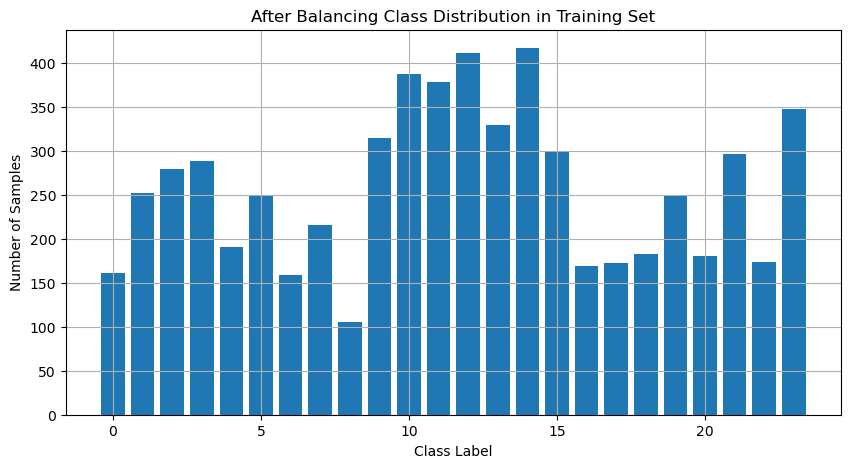

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Count samples per class
unique_classes, class_counts = np.unique(y_train, return_counts=True)

for label, count in zip(unique_classes, class_counts):
    print(f"Class {label}: {count} samples") # Print each class and respective samples

# Plotting the distribution of the classes
plt.figure(figsize=(10, 5))
plt.bar(unique_classes, class_counts)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("After Balancing Class Distribution in Training Set")
plt.grid(True)
plt.show()


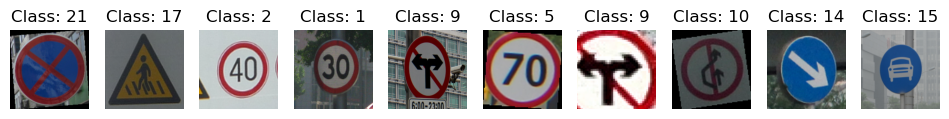

In [6]:
num_samples = 10 # Number of images to display
random_indices = random.sample(range(len(X_train)), num_samples)
#random_indices = np.size(random.sample(range(len(X_train)), 1))
#print(random_indices)
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    img_tensor = torch.tensor(X_train[idx])                 # Convert to tensor
    img = denormalize_image(img_tensor)                     # Undo normalization
    img = img.permute(1, 2, 0).numpy().clip(0, 1)            # [C, H, W] → [H, W, C]

    plt.imshow(img)    
    plt.title(f"Class: {y_train[idx]}")
    plt.axis("off")

plt.show()


In [7]:
test_folder = "Test"  # Replace with actual test folder name
test_images = []
test_labels = []

for img_file in os.listdir(test_folder):
    if img_file.endswith(".png"):
        img_path = os.path.join(test_folder, img_file)
        img = Image.open(img_path).convert("RGB")

        class_label = int(img_file.split("__")[0])

        # Preprocessing: only clean, no augmentation
        img = auto_crop(img)  # Optional but keeps it consistent
        img = resize_image(img, target_size)
        
        img = np.array(img) / 255.0
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
        img = normalize_image(img) # Normalize to [0, 1]

        test_images.append(img)
        test_labels.append(class_label)

X_test = np.array(test_images)
y_test = np.array(test_labels)

# this is my test data


In [8]:
print(np.shape(X_test))
print(np.shape(y_test))
print(len(np.unique(y_train)))

(2583, 3, 224, 224)
(2583,)
24


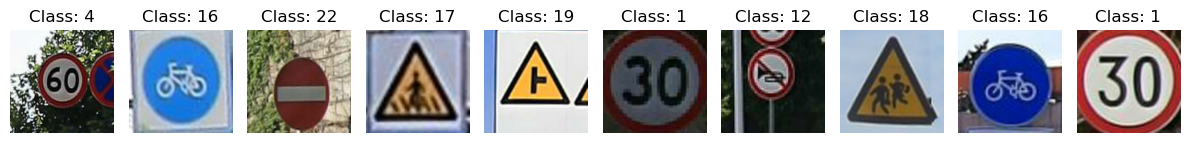

In [9]:
num_samples = 10
random_indices = random.sample(range(len(X_test)), num_samples)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)

    img_tensor = torch.tensor(X_test[idx])                 # Convert NumPy to torch
    img = denormalize_image(img_tensor)                    # Undo normalization
    img = img.permute(1, 2, 0).numpy().clip(0, 1)           # [C, H, W] → [H, W, C]

    plt.imshow(img)
    plt.title(f"Class: {y_test[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()



# CNN Modeling

## Loading Train and Test data

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

batch_size = 64

# Defining device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # Use GPU if available

# Convert preprocessed lists to tensors
X_all = torch.stack(train_images)
y_all = torch.tensor(y_train, dtype=torch.long)

# Split into training and validation (80% / 20%)
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# Also prepare the test set
X_test_tensor = torch.stack(test_images)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## CNN Model (Minimal layers)

In [ ]:
class CNN(nn.Module):
    def __init__(self, output_size=24):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)       # (3, 224, 224) -> (6, 220, 220)
        self.bn1 = nn.BatchNorm2d(6)                      # BatchNorm after first conv
        self.pool1 = nn.MaxPool2d(2, 2)                    # (6, 220, 220) -> (6, 110, 110)
        self.dropout1 = nn.Dropout2d(0.1)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)      # (6, 110, 110) -> (16, 106, 106)
        self.bn2 = nn.BatchNorm2d(16)                     # (16, 106, 106)
        self.pooMl2 = nn.MaxPool2d(2, 2)                    # (16, 106, 106) -> (16, 53, 53)
        self.dropout2 = nn.Dropout2d(0.2)   

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(2, 2)                    # (32, 53, 53) -> (32, 26, 26)
        self.dropout3 = nn.Dropout2d(0.15)      

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 26 * 26, 120)
        self.dropout_fc1 = nn.Dropout(0.3)                # Dropout after fc1
        self.fc2 = nn.Linear(120, 84)
        self.dropout_fc2 = nn.Dropout(0.5)                    # Dropout before final layer
        self.fc3 = nn.Linear(84, output_size)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))  # Apply first conv and pool
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.bn2(self.conv2(x))))  # Apply second conv and pool
        x = self.dropout2(x)

        x = self.pool3(F.relu(self.bn3(self.conv3(x))))  # Apply third conv and pool
        x = self.dropout3(x)

        x = x.view(x.size(0), -1)  # Flatten the output from the last convolutional layer

        x = F.relu(self.fc1(x))  # First fully connected layer
        x = self.dropout_fc1(x)

        x = F.relu(self.fc2(x))  # Second fully connected layer
        x = self.dropout_fc2(x)

        x = self.fc3(x)  # Final output layer
        return x


## Model Variables 

In [12]:
# Variables for our model
# (TO BE ADJUSTED BASED ON HOW WE WANT TO TRAIN THE MODEL)
n_features = 32 #32 convolutional filters in first conv layer 
learning_rate = 0.0001 #reduced learning rate for more stable training
num_epochs = 20

In [13]:
# Initialising the CNN model 
model = CNN(output_size=24)
model = model.to(device)

from sklearn.utils.class_weight import compute_class_weight


criterion = nn.CrossEntropyLoss()


# Set optimizer with optimizer (can change) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.0005)  #used Adam optimiser instead: converges faster and better for classification tasks


## Model Training

In [14]:
val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # 🔍 Validation evaluation
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            v_loss = criterion(val_outputs, val_labels)
            val_loss += v_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f} - Train Acc: {train_accuracy:.2f}% - "
          f"Val Loss: {avg_val_loss:.4f} - Val Acc: {val_accuracy:.2f}%")


Epoch [1/20] - Train Loss: 2.9572 - Train Acc: 13.47% - Val Loss: 2.4532 - Val Acc: 54.59%
Epoch [2/20] - Train Loss: 2.4486 - Train Acc: 30.43% - Val Loss: 1.7611 - Val Acc: 70.93%
Epoch [3/20] - Train Loss: 1.9216 - Train Acc: 47.06% - Val Loss: 1.1991 - Val Acc: 79.31%
Epoch [4/20] - Train Loss: 1.5249 - Train Acc: 57.33% - Val Loss: 0.8903 - Val Acc: 83.41%
Epoch [5/20] - Train Loss: 1.2844 - Train Acc: 63.33% - Val Loss: 0.6961 - Val Acc: 85.59%
Epoch [6/20] - Train Loss: 1.0752 - Train Acc: 69.08% - Val Loss: 0.5375 - Val Acc: 88.16%
Epoch [7/20] - Train Loss: 0.9302 - Train Acc: 72.87% - Val Loss: 0.4480 - Val Acc: 90.50%
Epoch [8/20] - Train Loss: 0.8105 - Train Acc: 76.83% - Val Loss: 0.3539 - Val Acc: 92.51%
Epoch [9/20] - Train Loss: 0.7136 - Train Acc: 79.33% - Val Loss: 0.3007 - Val Acc: 93.48%
Epoch [10/20] - Train Loss: 0.6115 - Train Acc: 81.90% - Val Loss: 0.2649 - Val Acc: 93.64%
Epoch [11/20] - Train Loss: 0.5629 - Train Acc: 83.66% - Val Loss: 0.2284 - Val Acc: 95.2

## Plotting Train Loss and Train Accuracy

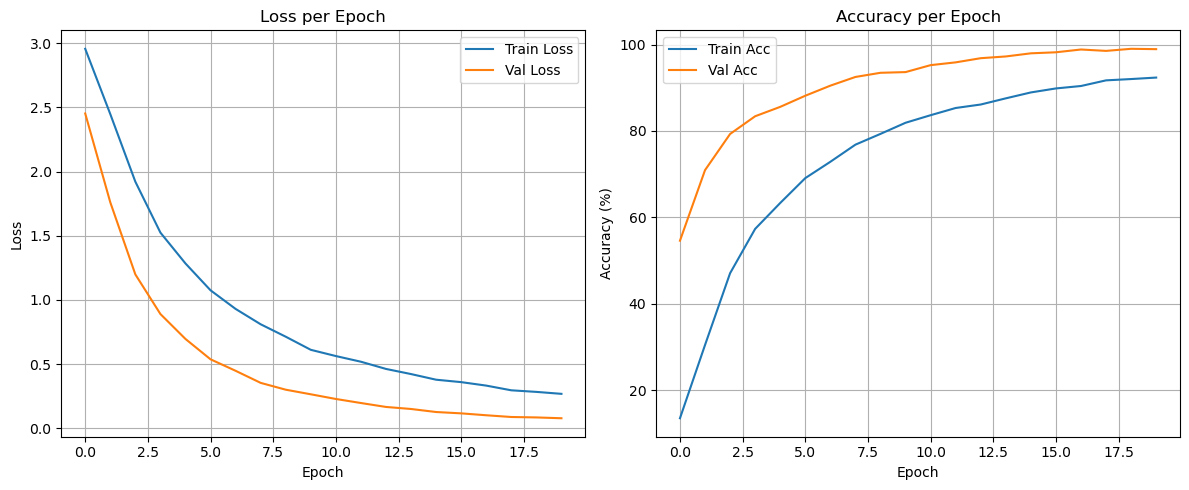

In [15]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Model Testing 

### Model Evaluation: Confusion Matrix


Test Loss: 0.9809
Test Accuracy: 72.94%


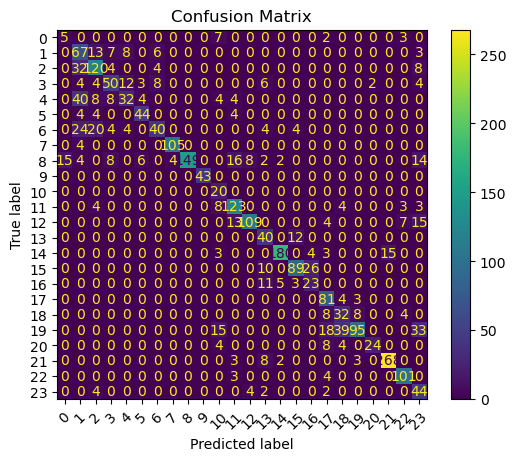

              precision    recall  f1-score   support

           0      0.250     0.294     0.270        17
           1      0.374     0.644     0.473       104
           2      0.678     0.714     0.696       168
           3      0.617     0.538     0.575        93
           4      0.571     0.320     0.410       100
           5      0.772     0.786     0.779        56
           6      0.690     0.400     0.506       100
           7      0.963     0.963     0.963       109
           8      1.000     0.654     0.790       228
           9      1.000     1.000     1.000        43
          10      0.328     1.000     0.494        20
          11      0.741     0.848     0.791       145
          12      0.901     0.736     0.810       148
          13      0.482     0.769     0.593        52
          14      0.952     0.878     0.914       205
          15      0.824     0.712     0.764       125
          16      0.434     0.548     0.484        42
          17      0.623    

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = []
y_pred = []

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Final metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, digits=3))


## ResNet18 CNN Model 



In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.nn import Linear 
from torchvision.models import resnet18, ResNet18_Weights


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


num_classes = len(torch.unique(y_train_tensor))
# Load pretrained ResNet and modify the last layer
resnet_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet_model.fc = Linear(in_features= 512, out_features = 24) # Adjust output layer
model = resnet_model.to(device)

# Variables for our model
learning_rate = 0.0001 #reduced learning rate for more stable training
num_epochs = 20

In [10]:

# Set Loss function with criterion (can change i think)
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer (can change) 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

In [ ]:
#print(summary(model.to("cpu"), input_size=(3, 224, 224), device="cpu"))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [11]:
# TRAINING 
val_accuracies = []
val_losses = []
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

# Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        # Calculate accuracy by calculating loss against predicted loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    #store losses and accuracy in train_losses and train_accuracies
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            v_loss = criterion(val_outputs, val_labels)
            val_loss += v_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f} - Train Acc: {train_accuracy:.2f}% - "
          f"Val Loss: {avg_val_loss:.4f} - Val Acc: {val_accuracy:.2f}%")


Epoch [1/20] - Train Loss: 3.0653 - Train Acc: 14.23% - Val Loss: 2.6712 - Val Acc: 30.02%
Epoch [2/20] - Train Loss: 2.4034 - Train Acc: 42.00% - Val Loss: 2.1009 - Val Acc: 55.30%
Epoch [3/20] - Train Loss: 1.8878 - Train Acc: 63.72% - Val Loss: 1.6492 - Val Acc: 70.79%
Epoch [4/20] - Train Loss: 1.4920 - Train Acc: 76.30% - Val Loss: 1.3222 - Val Acc: 79.78%
Epoch [5/20] - Train Loss: 1.2095 - Train Acc: 81.92% - Val Loss: 1.0814 - Val Acc: 84.83%
Epoch [6/20] - Train Loss: 0.9946 - Train Acc: 86.90% - Val Loss: 0.9039 - Val Acc: 88.76%
Epoch [7/20] - Train Loss: 0.8364 - Train Acc: 89.50% - Val Loss: 0.7675 - Val Acc: 90.45%
Epoch [8/20] - Train Loss: 0.7118 - Train Acc: 91.89% - Val Loss: 0.6539 - Val Acc: 92.94%
Epoch [9/20] - Train Loss: 0.6132 - Train Acc: 93.70% - Val Loss: 0.5606 - Val Acc: 94.46%
Epoch [10/20] - Train Loss: 0.5337 - Train Acc: 95.10% - Val Loss: 0.4954 - Val Acc: 95.59%
Epoch [11/20] - Train Loss: 0.4679 - Train Acc: 95.99% - Val Loss: 0.4342 - Val Acc: 96.5

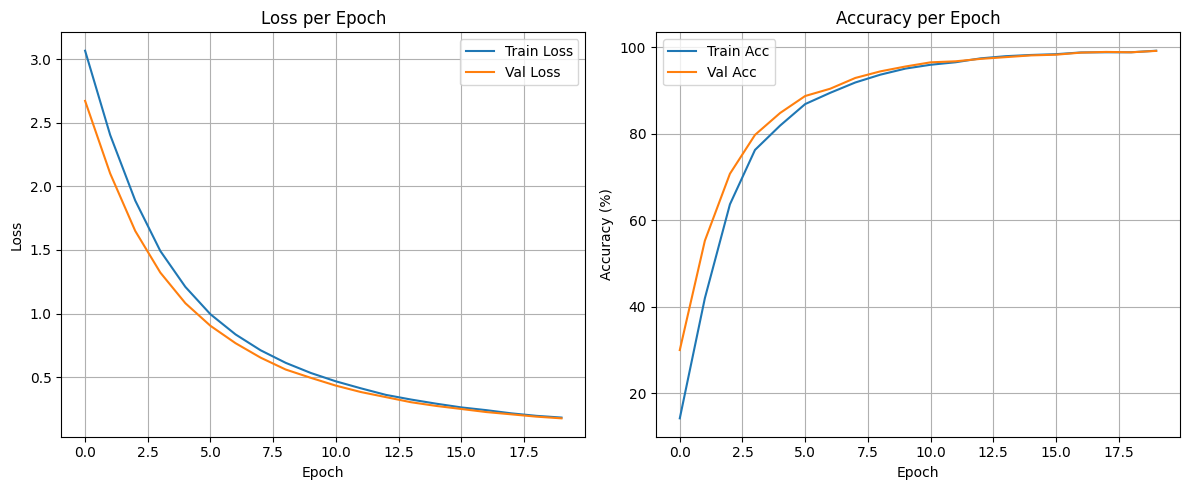

In [12]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Test Loss: 0.8109
Test Accuracy: 82.19%


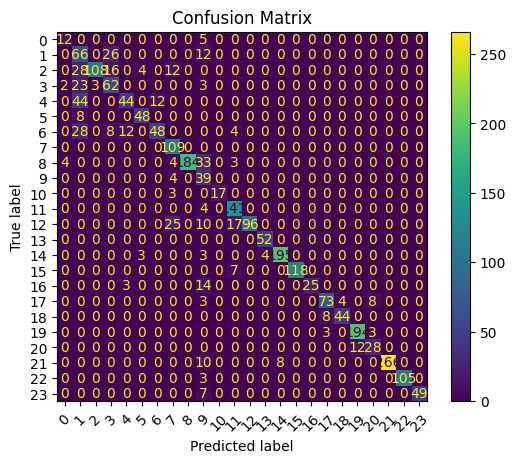

              precision    recall  f1-score   support

           0      0.667     0.706     0.686        17
           1      0.335     0.635     0.439       104
           2      0.973     0.643     0.774       168
           3      0.554     0.667     0.605        93
           4      0.746     0.440     0.553       100
           5      0.873     0.857     0.865        56
           6      0.800     0.480     0.600       100
           7      0.694     1.000     0.820       109
           8      1.000     0.807     0.893       228
           9      0.267     0.907     0.413        43
          10      1.000     0.850     0.919        20
          11      0.820     0.972     0.890       145
          12      1.000     0.649     0.787       148
          13      0.929     1.000     0.963        52
          14      0.961     0.951     0.956       205
          15      1.000     0.944     0.971       125
          16      1.000     0.595     0.746        42
          17      0.869    

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = []
y_pred = []

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Final metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, digits=3))

### Second resnet version ( kaiyi sent in telegram)


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.nn import Linear 
from torchvision.models import resnet18, ResNet18_Weights

n_features = 512 # for ResNet18 is 512. 
learning_rate = 0.0005
num_epochs = 10
num_classes = len(torch.unique(y_train_tensor))
batch_size = 64

In [26]:
# Load pretrained ResNet and modify the last layer
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# resnet_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model = model.to(device)
model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=24, bias=True), 
                        nn.Dropout(0.3))
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze only the last fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True
# Optimiser 
optimizer = torch.optim.AdamW(model.fc.parameters(), lr=0.0005 , weight_decay=0.0001) #unfreeze the last fc parameter

# Use in your loss function
criterion = nn.CrossEntropyLoss()

In [29]:
# TRAINING 
model = model.to(device)

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

# Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() #values of prev will not affect currrent epoch
        loss.backward()
        optimizer.step() 

        # Calculate accuracy by calculating loss against predicted loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    #store losses and accuracy in train_losses and train_accuracies
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)         

    torch.mps.empty_cache()


    print(f"Epoch [{epoch+1}/{num_epochs}] - " f"Train Loss: {avg_train_loss:.4f} - Train Acc: {train_accuracy:.2f}%")

Epoch [1/10] - Train Loss: 2.4216 - Train Acc: 36.19%
Epoch [2/10] - Train Loss: 1.5355 - Train Acc: 60.15%
Epoch [3/10] - Train Loss: 1.2718 - Train Acc: 63.52%
Epoch [4/10] - Train Loss: 1.1381 - Train Acc: 65.70%
Epoch [5/10] - Train Loss: 1.0362 - Train Acc: 67.52%
Epoch [6/10] - Train Loss: 0.9813 - Train Acc: 68.31%
Epoch [7/10] - Train Loss: 0.9511 - Train Acc: 68.05%
Epoch [8/10] - Train Loss: 0.8874 - Train Acc: 69.96%
Epoch [9/10] - Train Loss: 0.8706 - Train Acc: 70.08%
Epoch [10/10] - Train Loss: 0.8182 - Train Acc: 71.30%


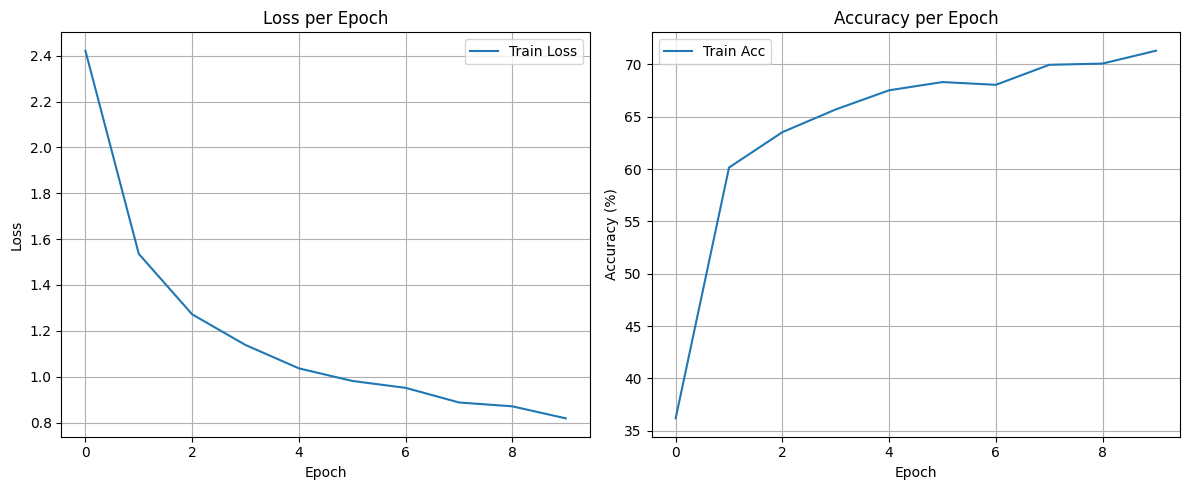

In [30]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Test Loss: 1.1157
Test Accuracy: 67.71%


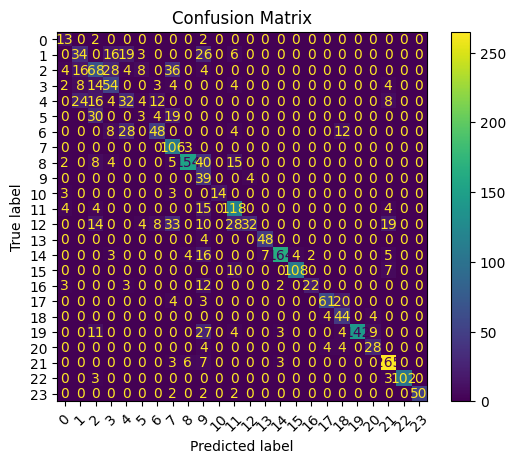

              precision    recall  f1-score   support

           0      0.419     0.765     0.542        17
           1      0.415     0.327     0.366       104
           2      0.400     0.405     0.402       168
           3      0.462     0.581     0.514        93
           4      0.372     0.320     0.344       100
           5      0.136     0.054     0.077        56
           6      0.640     0.480     0.549       100
           7      0.493     0.972     0.654       109
           8      0.922     0.675     0.780       228
           9      0.185     0.907     0.307        43
          10      1.000     0.700     0.824        20
          11      0.618     0.814     0.702       145
          12      0.889     0.216     0.348       148
          13      0.873     0.923     0.897        52
          14      0.953     0.800     0.870       205
          15      0.964     0.864     0.911       125
          16      0.917     0.524     0.667        42
          17      0.884    

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = []
y_pred = []

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Final metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, digits=3))

## VGG16 CNN Pre-trained Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.nn import Linear
from torchvision.models import vgg16, VGG16_Weights

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

num_classes = len(torch.unique(y_train_tensor))

# Load the pretrained VGG16 model (pretrained on imagenet)
vgg16_model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# Modified the final fully connected layer (classifier) with our classes
vgg16_model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

# Move the model to the configured device (GPU/CPU)
vgg16_model = vgg16_model.to(device)

# Check the model architecture
#summary(vgg16_model, (3, 224, 224))  # Assuming your input images are 224x224 RGB images


In [289]:

# Set Loss function with criterion (can change i think)
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer (can change) 
optimizer = torch.optim.SGD(vgg16_model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

In [291]:
# TRAINING 

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    vgg16_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

# Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = vgg16_model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        # Calculate accuracy by calculating loss against predicted loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    #store losses and accuracy in train_losses and train_accuracies
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - " f"Train Loss: {avg_train_loss:.4f} - Train Acc: {train_accuracy:.2f}%")

Epoch [1/20] - Train Loss: 3.0511 - Train Acc: 12.80%
Epoch [2/20] - Train Loss: 2.2459 - Train Acc: 39.11%


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = []
y_pred = []

vgg16_model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = vgg16_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Final metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, digits=3))